# Group wise PMF - RDK data

Reproduce the psychometric function plots of Experiment 2

(c) Anna-Lena Eckert

In [1]:
# import relevant modules
import os, sys, glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as s
import warnings

# import specific functions/ classes
from pathlib import Path
from scipy.stats import logistic
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr, kendalltau 
from scipy.stats import ttest_rel
from scipy.stats import f_oneway
from statsmodels.stats.anova import AnovaRM

# print settings for easier df inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

# suppress a ton of Jupyter related warnings
warnings. filterwarnings("ignore")

C:\Users\annae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\annae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# change into folder that contains data. 
path = os.getcwd()
p = Path(path).parents[1]
file_path = str(p) + '\\Data\\Exp2_visual\\'
os.chdir(file_path)

# read datafile
df = pd.read_csv('exp2_clean_pmf.csv')
subjects = list(df['sbj_id'].unique())
print('Number of included participants: ',len(subjects))
df.head()

Number of included participants:  41


,Unnamed: 0,Trial,Block,block_type,coherence,target,response,correct,cueValid,response_key,onset_rdk,end_rdk,onset_tone,onset_responseWin,rt,key_press,sbj_id,cue,resp_1,stim_1,caps,pdi,pdi_zscore,caps_zscore,PPS,block_type_z,coherence_z,target_z,response_z,correct_z,cueValid_z,response_key_z,rt_z,cue_z,resp_1_z,stim_1_z,caps_z,pdi_z,PPS_z
0,1,2,1,0,-0.3,0,0,1,1,0,1.629810e+09,1.629810e+09,1.629810e+09,1.629810e+09,2.02419,1.629810e+09,ANE14H,0.0,0.0,0.0,2.0,0.0,-1.074209,-0.586776,-1.660985,-1.0,-0.29277,-1.0,-1.021550,0.006189,0.577350,-0.150727,-0.069685,-1.001455,-1.021717,-0.999449,-0.586776,-1.074209,-0.869391
1,2,3,1,0,0.1,1,0,0,0,0,1.629810e+09,1.629811e+09,1.629810e+09,1.629811e+09,1.98846,1.629811e+09,ANE14H,0.0,0.0,0.0,2.0,0.0,-1.074209,-0.586776,-1.660985,-1.0,-1.46385,1.0,-1.021550,-0.192638,-1.732051,-0.150727,-0.076908,-1.001455,-1.021717,-0.999449,-0.586776,-1.074209,-0.869391
2,3,4,1,0,0.4,1,0,0,1,0,1.629811e+09,1.629811e+09,1.629811e+09,1.629811e+09,1.92622,1.629811e+09,ANE14H,1.0,0.0,1.0,2.0,0.0,-1.074209,-0.586776,-1.660985,-1.0,0.29277,1.0,-1.021550,-0.192638,0.577350,-0.150727,-0.089491,0.998548,-1.021717,1.000551,-0.586776,-1.074209,-0.869391
3,4,5,1,0,0.1,1,1,1,1,1,1.629811e+09,1.629811e+09,1.629811e+09,1.629811e+09,1.76285,1.629811e+09,ANE14H,1.0,0.0,1.0,2.0,0.0,-1.074209,-0.586776,-1.660985,-1.0,-1.46385,1.0,0.978905,0.006189,0.577350,0.047505,-0.122518,0.998548,-1.021717,1.000551,-0.586776,-1.074209,-0.869391
4,5,6,1,0,0.2,1,0,0,0,0,1.629811e+09,1.629811e+09,1.629811e+09,1.629811e+09,1.88462,1.629811e+09,ANE14H,0.0,1.0,1.0,2.0,0.0,-1.074209,-0.586776,-1.660985,-1.0,-0.87831,1.0,-1.021550,-0.192638,-1.732051,-0.150727,-0.097901,-1.001455,0.978745,1.000551,-0.586776,-1.074209,-0.869391


In [3]:
# define a PMF
def fit_PMF(df): 
    
    choices = df.loc[:,'response'].values
    stimuli = df.loc[:,'coherence'].values
    
    def minfun(params): 
        noise,bias = params
        cp= 1 / (1 + np.exp(-(stimuli - bias) / noise))
        model_p = cp * (choices==1) + (1-cp) * (choices==0)
        return -np.sum(np.log(np.maximum(1e-2,model_p)))
     
    noise,bias = minimize(minfun,[1,1],bounds=[(1e-2,1),(-10,10)]).x
    
    return bias, noise

In [4]:
# separate datafile: repetitive and neutral conditions, onto which we fit separate PMFs. 
# we need 4 dataframes: neut_left, neut_right, rep_left, rep_right.
# cave: coding of block differs between experiments. this is correct now.
# neutral blocks
neut_left = df[(df['block_type']==1) & (df['resp_1']==1)]
neut_right = df[(df['block_type']==1) & (df['resp_1']==0)]
# repetitive blocks
rep_left = df[(df['block_type']==0) & (df['resp_1']==1)]
rep_right = df[(df['block_type']==0) & (df['resp_1']==0)]


# get repetitive params
bias_rep_right, noise_rep_right = fit_PMF(rep_right)
bias_rep_left, noise_rep_left = fit_PMF(rep_left)
# get neutral params
bias_neut_right, noise_neut_right = fit_PMF(neut_right)
bias_neut_left, noise_neut_left = fit_PMF(neut_left)

In [5]:
def plot_PMF(bias_l, noise_l, bias_r, noise_r, ax, choices_l, stimuli_l, choices_r, stimuli_r):

    x = np.arange(-1,1,0.1)
    
    # logistic func
    logis = lambda x, beta, bias: 1/(1+np.exp(-(x-bias)/beta))
    
    # prev_left
    ax.plot(x, logis(x, noise_l, bias_l), label='previous left',color='#0A9094')
    threshold_l = np.interp(0.0, x, logis(x,noise_l,bias_l))
    
    # prev right
    ax.plot(x, logis(x, noise_r, bias_r), label='previous right',color='#D96923')
    threshold_r = np.interp(0.0, x, logis(x,noise_r,bias_r))
    
    # orienting lines
    ax.plot([0, 0], [0, 1], 'k-', alpha=0.4)
    ax.plot([-1, 1], [0.5, 0.5], 'k-',alpha=0.4)
    
    ax.set_xticks(np.arange(-1, 1, 0.5))
    
    # plot data frequencies
    for v in [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6]: 
        ax.plot(v, np.mean(choices_l[stimuli_l == v] == 1),'o', color='#0A9094',alpha=0.6)
        ax.plot(v, np.mean(choices_r[stimuli_r == v] == 1),'*', color='#D96923',alpha=0.6)
    
    plt.suptitle('Experiment 2', fontsize=20)
    
    plt.xlim([-1,1])
    plt.xticks(np.arange(-1, 1.1, 0.5))
    ax.legend(loc='best')
    fig.show()
    
# code coherence as floats not ints! Like in auditory. 

In [6]:
# choices and stimuli in the neutral blocks (for plotting of data frequency)
choices_l_n = neut_left.loc[:, 'response'].values   
stimuli_l_n = neut_left.loc[:, 'coherence'].values
choices_r_n = neut_right.loc[:, 'response'].values
stimuli_r_n = neut_right.loc[:, 'coherence'].values

# chocies and stimuli in repetitive blocks
choices_l_r = rep_left.loc[:, 'response'].values
stimuli_l_r = rep_left.loc[:, 'coherence'].values
choices_r_r = rep_right.loc[:, 'response'].values
stimuli_r_r = rep_right.loc[:, 'coherence'].values

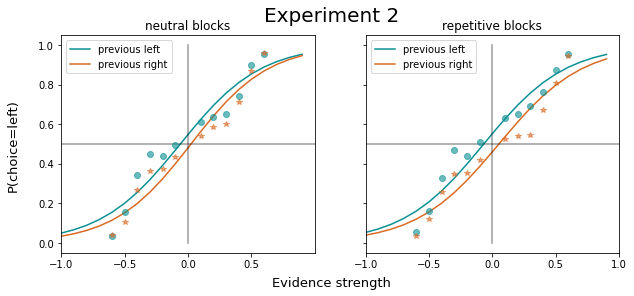

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))

plot_PMF(bias_neut_left, noise_neut_left, bias_neut_right, noise_neut_right, ax1, choices_l_n, stimuli_l_n, choices_r_n, stimuli_r_n)
ax1.title.set_text('neutral blocks')
ax1.set_xlim([-1, 1])
plot_PMF(bias_rep_left, noise_rep_left, bias_rep_right, noise_rep_right, ax2, choices_l_r, stimuli_l_r, choices_r_r, stimuli_r_r)
ax2.title.set_text('repetitive blocks')
ax2.set_xlim([-1, 1])

_ = fig.text(0.5, 0.01, 'Evidence strength' , ha='center', fontsize=13)
_ = fig.text(0.05, 0.5, 'P(choice=left)', va='center',rotation='vertical', fontsize=13)

plt.savefig('C:\\Users\\annae\\Desktop\\ChoiceHistory_Psych\\revision_SB2\\pmf_groupwise_exp2.svg')

In [9]:
def plot_PMF_BW(bias_l, noise_l, bias_r, noise_r, ax, choices_l, stimuli_l, choices_r, stimuli_r):

    x = np.arange(-1,1,0.1)
    
    # logistic func
    logis = lambda x, beta, bias: 1/(1+np.exp(-(x-bias)/beta))
    
    # prev_left
    ax.plot(x, logis(x, noise_l, bias_l), label='previous left',color='black')
    threshold_l = np.interp(0.0, x, logis(x,noise_l,bias_l))
    
    # prev right
    ax.plot(x, logis(x, noise_r, bias_r), label='previous right',color='grey')
    threshold_r = np.interp(0.0, x, logis(x,noise_r,bias_r))
    
    # orienting lines
    ax.plot([0, 0], [0, 1], 'k-', alpha=0.4)
    ax.plot([-1, 1], [0.5, 0.5], 'k-',alpha=0.4)
    
    ax.set_xticks(np.arange(-1, 1, 0.5))
    
    # plot data frequencies
    for v in [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6]: 
        ax.plot(v, np.mean(choices_l[stimuli_l == v] == 1),'o', color='black',alpha=0.6)
        ax.plot(v, np.mean(choices_r[stimuli_r == v] == 1),'*', color='grey',alpha=0.6)
    
    plt.suptitle('Experiment 2', fontsize=20)
    
    plt.xlim([-1,1])
    plt.xticks(np.arange(-1, 1.1, 0.5))
    ax.legend(loc='best')
    fig.show()
    
# code coherence as floats not ints! Like in auditory. 

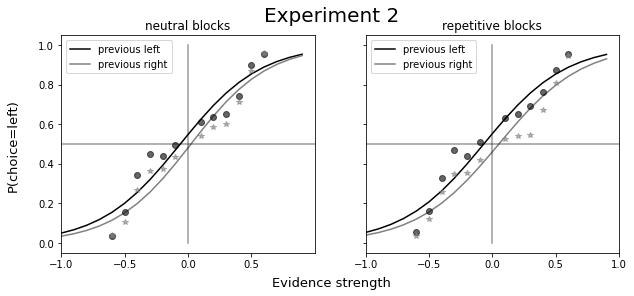

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))

plot_PMF_BW(bias_neut_left, noise_neut_left, bias_neut_right, noise_neut_right, ax1, choices_l_n, stimuli_l_n, choices_r_n, stimuli_r_n)
ax1.title.set_text('neutral blocks')
ax1.set_xlim([-1, 1])
plot_PMF_BW(bias_rep_left, noise_rep_left, bias_rep_right, noise_rep_right, ax2, choices_l_r, stimuli_l_r, choices_r_r, stimuli_r_r)
ax2.title.set_text('repetitive blocks')
ax2.set_xlim([-1, 1])

_ = fig.text(0.5, 0.01, 'Evidence strength' , ha='center', fontsize=13)
_ = fig.text(0.05, 0.5, 'P(choice=left)', va='center',rotation='vertical', fontsize=13)

plt.savefig('C:\\Users\\annae\\Desktop\\ChoiceHistory_Psych\\revision_SB2\\pmf_groupwise_exp2_BW.svg')